In [1]:
import numpy as np
import sys
from default_params import default_params
import torch
sys.path.append('..')
from rnn.model import RNN
from rnn.train import train_rnn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

%matplotlib inline

### Goal

We noticed that generally RNNs create long-time scales by using their recurrent connectivity instead of their membrane time constants - even when optimising their time constants. The goal of this notebook is to illustrate an example task in which RNNs need to learn long time scales by adjusting their membrane time constant instead of the weights.

The task will be having the RNN produce a slowly varying pattern, in this case a simple sine-wave

Note: in [recent work](https://arxiv.org/abs/2308.12585) (Figure 5B) authors show that a two neuron RNN exhibits a limit cycle for an increasingly smaller parameter range as the frequency of the cycle decreases. In that regime, we expect the networks to want to use the membrane time constants instead of the weights.

In [2]:
# create task

dt = 1
task_params={"n_cycles":1.2,
         "dt":dt,
         "freq":10,
        "trials_per_epoch":50}

class Cycle(Dataset):
    """
    Creates a task in which the target is reproducing a sinusoidal oscillation
    """

    def __init__(self, task_params):
        """
        Args, task_params: dictionary of task parameters
        """
        self.task_params=task_params
        
        self.trial_dur= int(task_params['n_cycles']*1000/(self.task_params['freq']*self.task_params['dt']))
        self.time = torch.arange(0,task_params['n_cycles']*np.pi*2,
                                 task_params['n_cycles']*np.pi*2/self.trial_dur)
        self.phase0 = torch.rand(1,)*np.pi*2
    def __len__(self):
        return self.task_params['trials_per_epoch']
        
    def __getitem__(self,idx):
        """
        Args, idx: trial number (arbitrary)
        Returns: input, target, mask
        """
        sin = torch.sin(self.time+self.phase0)
        cos = torch.cos(self.time+self.phase0)
        target= torch.stack([sin,cos])
        return torch.zeros(self.trial_dur,1),target.T,torch.ones(self.trial_dur,1)

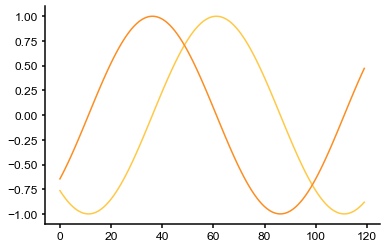

In [3]:
# plot example target
cycle = Cycle(task_params)
_,target,_ = cycle[1]
plt.plot(target.detach())


### Now train models
We train on models with varying frequencies, and illustrate that for low-frequency oscillations only the models with trainable membrane time constants do the task

The RNN consists of $N$ units, with activation $\mathbf{x}(t)\in \mathcal{R}^N$, recurrently connected via a connectivity matrix $\mathbf{J} \in \mathcal{R}^{N\times N}$, and receiving input $\mathbf{u}(t) \in \mathcal{R}^{3}$,
\begin{equation}\tau \frac{d\mathbf{x}}{dt}=-\mathbf{x}(t)+\mathbf{J} \tanh(\mathbf{x}(t))+\mathbf{I}\mathbf{u}(t)+\boldsymbol{\xi}(t),
\end{equation}
 where $\tau$ represents the time constant of the units, $\tanh$ is an elementwise non-linearity, $\mathbf{I}\in \mathcal{R}^{N\times3}$ represents the input weights, and $\boldsymbol{\xi}(t) \in {R}^N$ independent noise for each unit.

During training we discretize using the Euler-Maruyama method and use backpropagation through time to optimise the network parameters. We use a mean-squared error loss between the targets plotted above, and a linear readout from the network's activity: $\mathbf{W}^\mathsf{T}\tanh(\mathbf{x})$ 

In [4]:
# Set some model parameters

model_params, training_params, _ = default_params()
model_params['n_rec']=10
model_params['dt']=dt
model_params['train_x0']=True
model_params['n_out']=2
model_params['n_inp']=1
model_params['tau_mean']=10

model_params['tau_lims']=[5,100]


In [5]:
# Set learning parameters

frequencies = [.75, 1,1.5]
n_models = 3
training_params['n_epochs']=100
lrs = [0.01]
loss = torch.nn.MSELoss()


In [6]:
# Train networks without trainable taus

model_params['train_taus']=False
loss_table_untrained = np.zeros((len(frequencies),n_models, len(lrs)))
time_constants_untrained = np.zeros((len(frequencies),n_models, len(lrs)))
for lr_ind, lr in enumerate(lrs):
    training_params['lr']=lr
    for freq_ind, freq in enumerate(frequencies):
        for model_ind in range(n_models):
            task_params['freq']=freq
            rnn = RNN(model_params)
            cycle = Cycle(task_params)
            losses, reg_losses = train_rnn(rnn, training_params, cycle, sync_wandb=False)
            loss_table_untrained[freq_ind,model_ind,lr_ind] = np.mean(losses[-10:])

            mean_tau = np.mean(rnn.rnn.project_taus(rnn.rnn.taus_gaus,rnn.rnn.tau).detach().numpy())
            time_constants_untrained[freq_ind,model_ind,lr_ind] = mean_tau
            loss_table_untrained[freq_ind,model_ind,lr_ind] = np.mean(losses[-10:])



project taus sigmoid
spectral_rad: 1.0
epoch 100 / 100: time=241.6 s, task loss=0.85376, reg loss=0.00000
Done. Training took 241.6 sec.
project taus sigmoid
spectral_rad: 1.0
epoch 100 / 100: time=241.9 s, task loss=0.98735, reg loss=0.00000
Done. Training took 241.9 sec.
project taus sigmoid
spectral_rad: 0.99999994
epoch 100 / 100: time=241.8 s, task loss=0.65545, reg loss=0.00000
Done. Training took 241.8 sec.
project taus sigmoid
spectral_rad: 0.99999994
epoch 100 / 100: time=179.3 s, task loss=0.36044, reg loss=0.00000
Done. Training took 179.3 sec.
project taus sigmoid
spectral_rad: 1.0
epoch 100 / 100: time=179.2 s, task loss=0.68664, reg loss=0.00000
Done. Training took 179.2 sec.
project taus sigmoid
spectral_rad: 1.0
epoch 100 / 100: time=179.1 s, task loss=0.87162, reg loss=0.00000
Done. Training took 179.1 sec.
project taus sigmoid
spectral_rad: 1.0
epoch 100 / 100: time=117.4 s, task loss=0.04410, reg loss=0.00000
Done. Training took 117.4 sec.
project taus sigmoid
spectr

In [8]:
# Train networks with trainable taus

model_params['train_taus']=True
loss_table_trained = np.zeros((len(frequencies),n_models, len(lrs)))
time_constants_trained = np.zeros((len(frequencies),n_models, len(lrs)))
for lr_ind, lr in enumerate(lrs):
    training_params['lr']=lr
    for freq_ind, freq in enumerate(frequencies):
        for model_ind in range(n_models):
            task_params['freq']=freq
            rnn = RNN(model_params)
            cycle = Cycle(task_params)
            losses, reg_losses = train_rnn(rnn, training_params, cycle, sync_wandb=False)
            loss_table_trained[freq_ind,model_ind,lr_ind] = np.mean(losses[-10:])
            mean_tau = np.mean(rnn.rnn.project_taus(rnn.rnn.taus_gaus,rnn.rnn.tau).detach().numpy())

            time_constants_trained[freq_ind,model_ind,lr_ind] = mean_tau



project taus sigmoid
spectral_rad: 1.0
epoch 100 / 100: time=348.0 s, task loss=0.01051, reg loss=0.00000
Done. Training took 348.0 sec.
project taus sigmoid
spectral_rad: 1.0
epoch 100 / 100: time=349.5 s, task loss=0.00947, reg loss=0.00000
Done. Training took 349.5 sec.
project taus sigmoid
spectral_rad: 0.99999994
epoch 100 / 100: time=349.9 s, task loss=0.03505, reg loss=0.00000
Done. Training took 349.9 sec.
project taus sigmoid
spectral_rad: 1.0
epoch 100 / 100: time=261.9 s, task loss=0.00854, reg loss=0.00000
Done. Training took 261.9 sec.
project taus sigmoid
spectral_rad: 1.0
epoch 100 / 100: time=264.1 s, task loss=0.01092, reg loss=0.00000
Done. Training took 264.1 sec.
project taus sigmoid
spectral_rad: 1.0
epoch 100 / 100: time=261.2 s, task loss=0.01169, reg loss=0.00000
Done. Training took 261.2 sec.
project taus sigmoid
spectral_rad: 1.0
epoch 100 / 100: time=169.8 s, task loss=0.01200, reg loss=0.00000
Done. Training took 169.8 sec.
project taus sigmoid
spectral_rad:

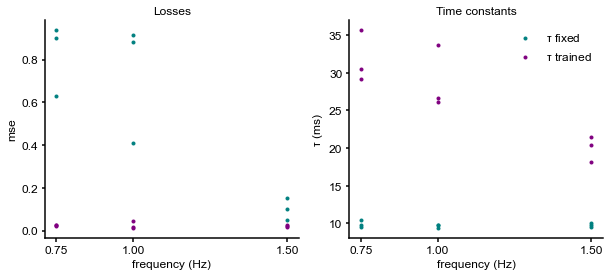

In [21]:
# plot results scatter

fig,ax = plt.subplots(1,2,figsize=(10,4))
uc = 'teal'
tc = 'purple'
for mod_ind in range(n_models-1):
    ax[0].scatter(frequencies, loss_table_untrained[:,mod_ind,0],color=uc)
    ax[1].scatter(frequencies, time_constants_untrained[:,mod_ind,0],color=uc)
    ax[0].scatter(frequencies, loss_table_trained[:,mod_ind,0],color=tc)
    ax[1].scatter(frequencies, time_constants_trained[:,mod_ind,0],color=tc)
mod_ind+=1
ax[0].scatter(frequencies, loss_table_untrained[:,mod_ind,0],color=uc)
ax[1].scatter(frequencies, time_constants_untrained[:,mod_ind,0],color=uc, label=r'$\tau$ fixed')
ax[0].scatter(frequencies, loss_table_trained[:,mod_ind,0],color=tc)
ax[1].scatter(frequencies, time_constants_trained[:,mod_ind,0],color=tc, label=r'$\tau$ trained')
ax[0].set_xticks(frequencies)
ax[1].set_xticks(frequencies)
ax[0].set_xlabel('frequency (Hz)')
ax[1].set_xlabel('frequency (Hz)')
ax[0].set_title('Losses')
ax[0].set_ylabel('mse')
ax[1].set_title('Time constants')
ax[1].set_ylabel(r'$\tau$ (ms)')
ax[1].legend()


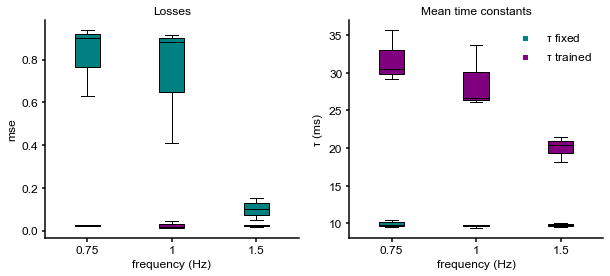

In [56]:
# plot results box

loss_u = {frequencies[0]: loss_table_untrained[0,:,0], 
           frequencies[1]: loss_table_untrained[1,:,0],
           frequencies[2]: loss_table_untrained[2,:,0]}
loss_t = {frequencies[0]: loss_table_trained[0,:,0], 
           frequencies[1]: loss_table_trained[1,:,0],
           frequencies[2]: loss_table_trained[2,:,0]}

tau_u = {frequencies[0]: time_constants_untrained[0,:,0], 
           frequencies[1]: time_constants_untrained[1,:,0],
           frequencies[2]: time_constants_untrained[2,:,0]}
tau_t = {frequencies[0]: time_constants_trained[0,:,0], 
           frequencies[1]: time_constants_trained[1,:,0],
           frequencies[2]: time_constants_trained[2,:,0]}

fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].boxplot(loss_u.values(), patch_artist=True,boxprops=dict(facecolor=uc),medianprops=dict(color='k'))
ax[0].boxplot(loss_t.values(), patch_artist=True, boxprops=dict(facecolor=tc),medianprops=dict(color='k'))
ax[0].set_xticks(range(1,4))
ax[0].set_xticklabels(loss_t.keys())

ax[1].boxplot(tau_u.values(), patch_artist=True,boxprops=dict(facecolor=uc),medianprops=dict(color='k'))
ax[1].boxplot(tau_t.values(), patch_artist=True, boxprops=dict(facecolor=tc),medianprops=dict(color='k'))
ax[1].set_xticks(range(1,4))
ax[1].set_xticklabels(loss_t.keys())
ax[1].scatter(1, np.median(time_constants_untrained[0,:,0]),color=uc,s=20, marker='s',label=r'$\tau$ fixed',zorder=-10)
ax[1].scatter(1, np.median(time_constants_trained[0,:,0]),color=tc,s=20, marker='s',label=r'$\tau$ trained',zorder=-10)
ax[1].legend()

ax[0].set_xlabel('frequency (Hz)')
ax[1].set_xlabel('frequency (Hz)')
ax[0].set_title('Losses')
ax[0].set_ylabel('mse')
ax[1].set_title('Mean time constants')
ax[1].set_ylabel(r'$\tau$ (ms)')
ax[1].legend()
